# What Cost/Loss Function Should I Use?
So clearly the cost/loss function that you choose has a large impact on training. This is, afterall, the training objective! What are some things that we should be mindful of when choosing a loss function? Well, we need to think about how machines learn. If we are using a gradient-based method of learning, then we should clearly be concerned about the gradients on a loss function. Therefore, we want the following properties of our loss function:
<br><br><br>
 1) No vanishing gradients ($\nabla \mathcal{L} = 0$) near suboptimal performance - This means we want to limit the number of local minima in our loss function  
 2) No exploding gradients ($\nabla \mathcal{L} \approx \infty$) - This will cause very large changes in our parameters which means we could be "skipping" over minima locations and ending up in very non-ideal configurations. It can also lead to runaway performance where the model just keeps getting worse and worse without improving as the gradient just keeps getting larger and larger  
 3) Continuity of the gradient - This means that gradient is defined at all points along the cost function. This may seem to be a given. However, for piece-wise loss functions or loss functions that include an absolute function, |x|, this will not be true. Therefore, in the regime of the loss function training can become unstable  
 <br><br><br>
Condition 2 can be identified typically by inspection. Poles (exploding parts of the function) usually arise from $\frac{1}{x}$ or logarithmic dependences. 3) can also be identified pretty easily most of the times (just compute the derivative and look for poles in derivative). However, 1) is usually the tricky one. In reality, any loss function you will use for any high dimensional problem will be riddled with local minima. Therefore, it is almost impossible to try and satisfy condition 1. So, are we left hopeless? Is there nothing we can do? Let me try and paint the scenario at hand first before we try and dwell on possible solutions.

In [2]:
from matplotlib import pyplot as plt
import torch

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [3]:
# Pretty plotting config
%run plot_conf.py

In [4]:
# Set style (need to be in a new cell)
plt_style()

In [5]:
 # generate uniformly spaced theta_1 values betwen -1000 and 1000 with step size of 0.5
theta_1 = torch.arange(-1000, 1000, 0.5)

# generate uniformly spaced theta_2 values betwen -1000 and 1000 with step size of 0.5
theta_2 = torch.arange(-1000, 1000, 0.5)

# compute all pairs between theta_1 and theta_2, creates a grid of theta_1, theta_2 values
theta_1,theta_2 = np.meshgrid(theta_1, theta_2) 
theta_1 = torch.Tensor(theta_1) # convert to torch tensor
theta_2 = torch.Tensor(theta_2) # convert to torch tensor

# our loss function
L = -(theta_2 + 47) * torch.sin(torch.sqrt(torch.abs(theta_2 + 0.5 * theta_1 + 47))) - theta_1 * torch.sin(torch.sqrt(torch.abs(theta_1 - (theta_2 + 47))))

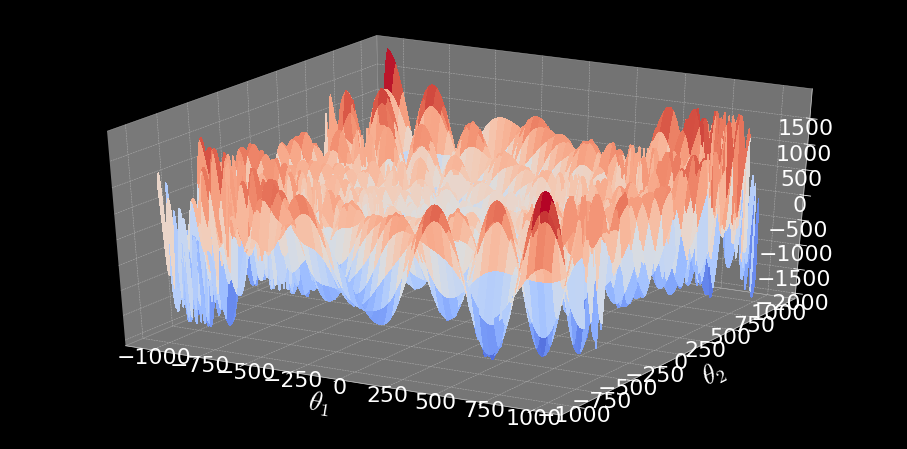

In [6]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}) # set-up plotting for 3D

# plot 3D loss surface
surf = ax.plot_surface(theta_1.numpy(), theta_2.numpy(), L.numpy(), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.tick_params(axis='both', which='major', pad=-10) # move tick labels so you can see x/y-axis labels
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.show()

Imagine this is our loss function. Given any initial random starting point of our model's parameters ($\theta_1$ and $\theta_2$ here), it seems by using a gradient-based learning algorithm we are almost destined to be in a local minima! To simplify the picture a bit, let's look at a 1D slice of this "loss function" at $\theta_2$ = 50.

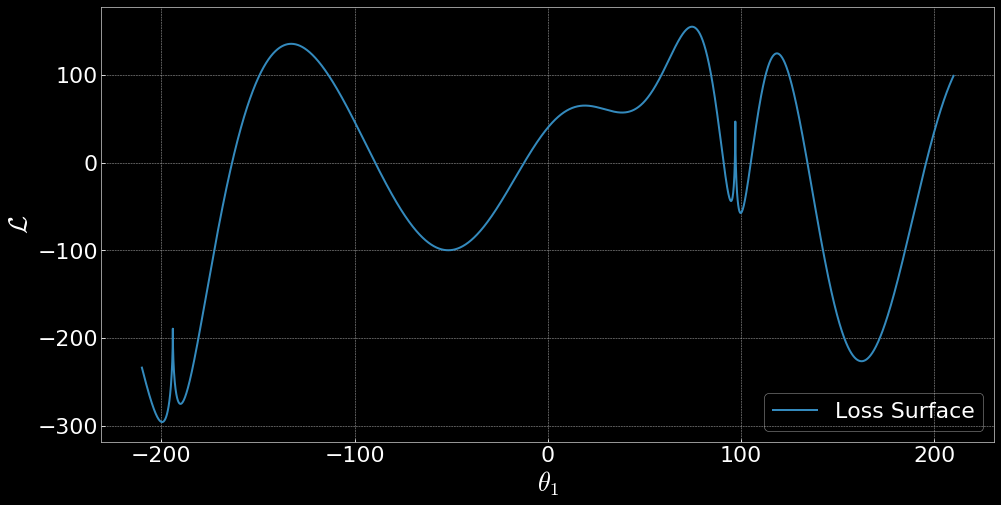

In [7]:
# hold theta_2 constant and look at a slice in the theta_1 direction
theta_1 = torch.arange(-210, 210, 0.1) # theta_1 is between -210 to 210 in steps of 0.1
theta_2_0 = 50 # theta_2 is held constant at 50
L = -(theta_2_0 + 47) * torch.sin(torch.sqrt(torch.abs(theta_2_0 + 0.5 * theta_1 + 47))) - theta_1 * torch.sin(torch.sqrt(torch.abs(theta_1 - (theta_2_0 + 47))))
plt.plot(theta_1.numpy(), L.numpy(), label='Loss Surface')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\mathcal{L}$')
plt.legend()
plt.show()

We can clearly see that the global minimum at around $\theta_1 = -200$ is going to be nearly impossible to reach with standard gradient descent. This is because only if you randomly start in the region $[-210, 195]$ or so, will you ever reach this global minimum. Go ahead, try it out!

In [8]:
def loss(theta1, theta2_0):
    """
    Computes the loss of the above 3D loss surface for a given theta2_0 value at a specified theta1 location.
    
    :param theta1: The theta1 value to evaulated our 1D loss function slice at
    :param theta2_0: The theta2 value to hold constant at
    """
    return -(theta2_0 + 47) * torch.sin(torch.sqrt(torch.abs(theta2_0 + 0.5 * theta1 + 47))) - theta1 * torch.sin(torch.sqrt(torch.abs(theta1 - (theta2_0 + 47))))

def derivative_descent(theta=torch.Tensor([1.5]), T=10, alpha=0.01, plot_loss_surface=False, plotting=True, loss=loss):
    '''
    Function that will descend the function loss for some initial theta value (theta), number of time steps (T) and 
    amount to multiply tangent slope by (alpha).
    
    :param theta: The initial starting value of theta at t = 0
    :param T: The number of time steps to perform.
    :param alpha: The number less than 1 to multiply the slope of the tangent line by.
    :param plot_loss_surface (bool): Whether or not to plot the hypothetical loss surface
    :param plotting (bool): Whether or not to plot theta at different time steps
    :param loss (function): The loss function to perform derivative descent on
    '''
    
    # generate theta values between [-|theta_0| - 0.5, |theta_0| + 0.5] in steps of 0.01 for plotting
    theta_1s = torch.arange(-210, 210, 0.1)
    theta2_0 = torch.Tensor([50])
    theta2_0.requires_grad = True
    
    # compute the cost function 
    losses = loss(theta_1s, theta2_0)
    if plot_loss_surface: # plot the loss function
        plt.plot(theta_1s.detach().numpy(), losses.detach().numpy(), label='Loss Function')
    
    # store the value of theta at different time steps and the corresponding loss
    theta_ts = [] # theta at different time steps
    L_ts = [] # corresponding loss

    for t in range(T): # perform T time steps
        if t == 0: # set the variables to their initial value
            theta_t = theta
            theta_ts.append(theta_t.detach().clone()) # we need to clone since theta_t is a torch Tensor
            L_ts.append(loss(theta_t, theta2_0).detach().numpy())
        else:
            L_t = loss(theta_t, theta2_0[0])
            L_t.backward()
            theta_t.data -= alpha * theta_t.grad.data # update theta
            theta_t.grad = None
            
            theta_ts.append(theta_t.detach().clone().numpy()) # add new theta to list of thetas at different time steps
            L_ts.append(loss(theta_t, theta2_0).detach().numpy()) # add new loss for corresponding new theta value
    
            
    if plotting: # plot theta at different time steps                           
        plt.scatter(theta_ts, L_ts, label=r'$\theta_1$ at different time steps', color='r', s=25)
        plt.xlabel(r'$\theta_1$')
        plt.ylabel('$\mathcal{L}$')
        plt.legend()
        plt.show()
    return L_ts[-1]

In [9]:
theta_i = 420 * (torch.rand(1) - 0.5) # sample x randomly between -210 to 210
theta_i.requires_grad = True

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


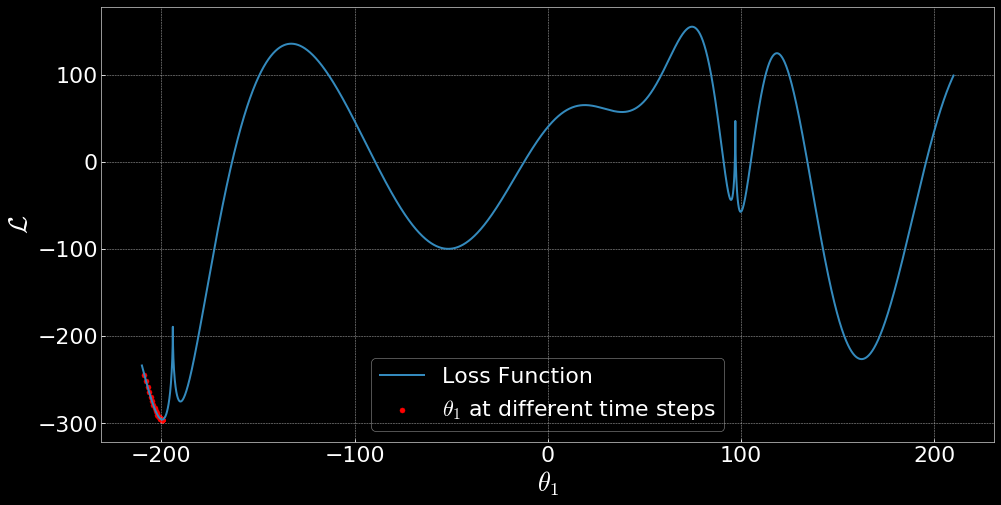

array([-295.7757], dtype=float32)

In [11]:
derivative_descent(theta_i, T=1000, alpha=0.1, plot_loss_surface=True, loss=loss)

Remember that in general, we **do not know** the loss surface dependence on our parameters of our model! Therefore, what we actually see is something more like this:

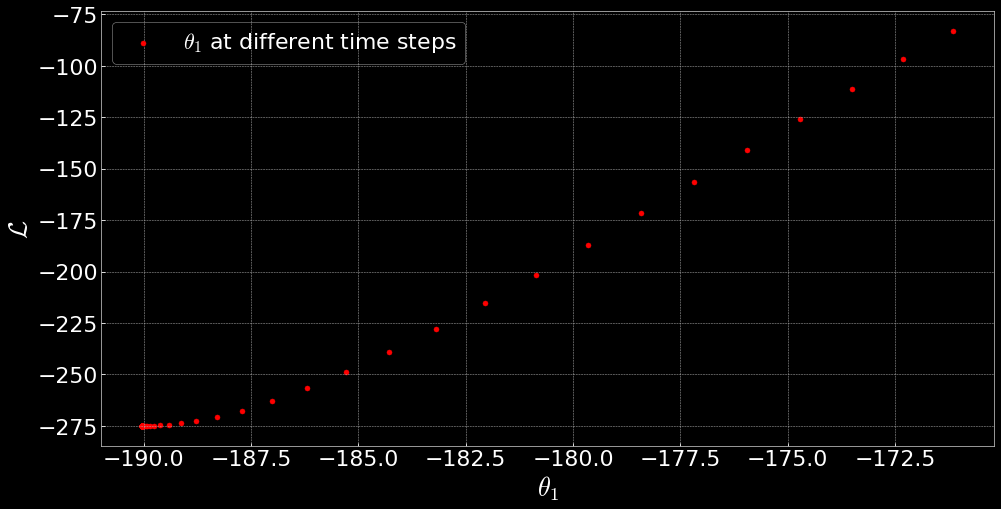

array([-275.08527], dtype=float32)

In [12]:
theta_i = 420 * (torch.rand(1) - 0.5) # sample x randomly between -210 to 210
theta_i.requires_grad = True
derivative_descent(theta_i, T=1000, alpha=0.1, plot_loss_surface=False, loss=loss)

Now, what you might say is "AJ, we just need to increase the learning rate! This will allow us to jump over these hills!" Go ahead. Try it. It's not going to work and if you get it to work you are just lucky. Run it again with the same learning rate and you won't end up in the global minima.

Another approach to solving this problem is simply to just pick a good initial starting point. However, without any prior knowledge of the dependence of the loss function on your model's parameters, this is very very hard to do. However, it may always be worthwhile to do a couple of initializiations of your model if you are getting very poor performance to ensure it is not just a throw of the die and you started in a very unlucky initial starting point. This is typically not the case for bad model performance, however.

One of the more ingenius approaches to solving this problem is by adding momentum and friction into the gradient descent. What I mean by this is the following: Imagine that you place a ball at your initial starting point. As the ball descends the gradient, this ball will pick up momentum. When the ball reaches the minima, it will therefore continue up the other side of the valley. If this is a local minima, then the momentum that the ball has will potentially carry it over the hill and into the next local minima. However, when it gets in a nice, deep well it will oscillate around in that well until it dissipates all of its "energy/momentum". However, this is not an end-all be-all solution to optimization. Clearly, if we start in the vicinity of the local minima at $x = ~160$, we will never have enough momentum to get out of this well.

One such optimizer that uses this idea of momentum is the Adam optimizer, which is derived from **Ada**ptive **m**oment estimation. However, Adam comes with a price. Adam introduces two more hyperparameters in addition to the single hyperparameter we've had thus far, learning rate, by the means of $\beta_1$ and $\beta_2$. $\beta_1$ is related to calculation of the momentum. Essentially the closer to 1 $\beta_1$ is, the less friction there is and the more likely it is for the ball to go over the hill. For our ad-hock loss function, let's try benchmarking the performance between the two learning algorithms.

In [18]:
gradient_descent_losses = [] # store final loss from gradient descent in this list

N = 100 # Do 100 random trials to benchmark performance of pure gradient descent

for i in range(N): # 100 random trials
    theta1 = 420 * (torch.rand(1) - 0.5) # sample theta randomly between -210 to 210
    theta1.requires_grad = True
    # Try setting plotting = True to inspect the differences between Adam and Gradient descent
    # but don't let N be too large - might kill your PC/Jupyter Notebook session
    gradient_descent_losses.append(derivative_descent(theta=theta1, T=3000, alpha=0.1, plotting=False, loss=loss))

In [17]:
from torch.optim import Adam

In [19]:
def adam_descent(theta1=1.5, T=10, alpha=0.1, plotting=True, betas=(0.9, 0.999), loss=loss):
    """
    Function to descend a loss function using Adam
    
    :param theta1: The initial value of your parameter of your model
    :param T: How many time steps to take
    :param alpha: The learning rate
    :param plotting (bool): Whether or not to plot the loss surface and time steps
    :param betas (tuple): The beta hyperparameters for Adam. betas[0] = beta_1 and betas[1] = beta_2
    :param loss (function): The loss function we will be descending"""
    
    theta1s = torch.arange(-210, 210, 0.1) # generate all theta1s so we can plot entire loss function
    theta2_0 = 50 # fix theta2
    losses = loss(theta1s, theta2_0) # compute the loss surface over all theta1's
    if plotting:
        plt.plot(theta1s.detach().numpy(), losses.detach().numpy(), label='Loss Function')
    
    theta1_ts = [] # store the updated theta1 as a function of time
    L_ts = [] # store the losses as well
    
    theta1_t = theta1
    optimizer = Adam([theta1_t], lr=alpha, betas=betas)


    for t in range(T):
        if t == 0:
            theta1_ts.append(theta1_t.detach().clone())
            L_ts.append(loss(theta1_t, theta2_0).detach())
        else:
            L_t = loss(theta1_t, theta2_0)
            L_t.backward()
            optimizer.step()
            theta1_t.grad = None
    
            theta1_ts.append(theta1_t.detach().clone())
            L_t = -(theta2_0 + 47) * torch.sin(torch.sqrt(torch.abs(theta2_0 + 0.5 * theta1_t + 47))) - theta1_t * torch.sin(torch.sqrt(torch.abs(theta1_t - (theta2_0 + 47))))
            L_ts.append(L_t.detach())

    if plotting:                      
        plt.scatter(theta1_ts, L_ts, label='x at different time steps', color='r', s=25)
        plt.legend()
        plt.show()
    return L_ts[-1]

In [20]:
# Note I am changing the default hyperparameters of Adam to give it "more momentum" or "less friction"
# beta1 = 0.9 is default, I am giving it 0.9999
# beta2 = 0.999 is default
# I am also giving it more time since because there is more momentum we need to give it more time to stop
# oscillating. You can go ahead and give more time to gradient descent but it won't change anything
adam_descent_losses = []
N = 100
for i in range(N):
    theta1_i = 420 * (torch.rand(1) - 0.5) # sample theta1 randomly between -210 to 210
    theta1_i.requires_grad = True
    adam_descent_losses.append(adam_descent(theta1=theta1_i, T=5000, alpha=0.001, betas=(0.9, 0.999), plotting=False), loss=loss)

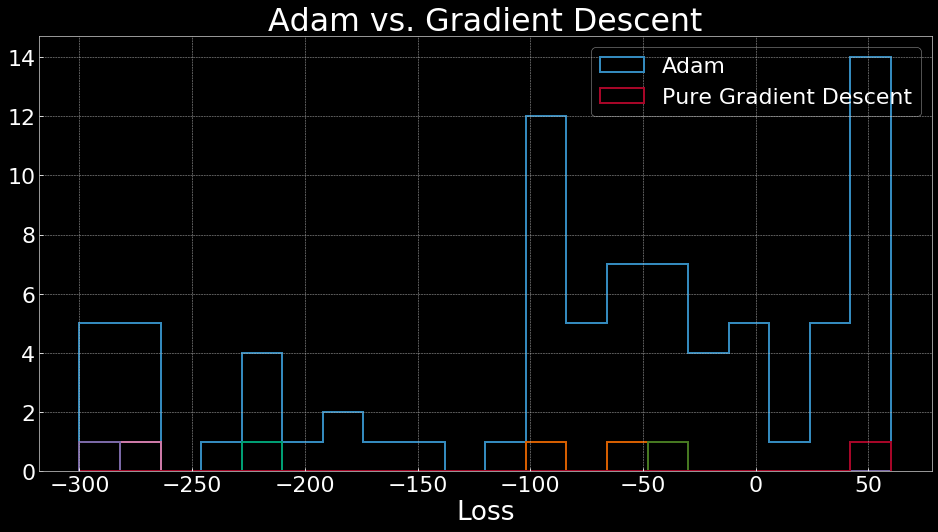

In [21]:
plt.hist(adam_descent_losses, label='Adam', histtype='step', linewidth=2.0, bins=20, range=(-300, 60))
plt.hist(gradient_descent_losses, label='Pure Gradient Descent', histtype='step', linewidth=2.0, bins=20, range=(-300, 60))
plt.xlabel('Loss')
plt.title('Adam vs. Gradient Descent')
plt.legend()
plt.show()

So we can see that Adam does help overcome some valleys but in general if there is a moderately high peak separating minima you will need to "decrease the friction" by a lot to overcome that peak and from that you will suffer from your optimizer oscillating around for a long time and possibly missing out on "easy" optima.

The last solution to solve this problem is definitely outside of the box and that is changing the loss function itself. Now, we aren't going to pick an entirely new loss function. Let's say we think that this is a good loss function or better than all the alternatives. However, it is still riddled with local minima. How can we change this loss function such that is is easier to reach the global minima? Well, you can simply add a term onto your loss function which attempts to get rid of the valleys and peaks inbetween where you start and your global minima. For example:

$$
\hat{\mathcal{L}} = \mathcal{L} + \lambda R\left(\vec{x}, \vec{\theta}, \vec{y}, \hat{y}\right)
$$
where $\hat{\mathcal{L}}$ is your new, regularized loss function and $\lambda$ is the regularization strength of your regularizer. Let's try adding the regularizer:

$$
R\left(\vec{x}, \vec{\theta}, \vec{y}, \hat{y}\right) = (x + 180)^2
$$

In [32]:
def plot_regularized_loss(regularization_strength=0.1):
    """
    Plots the loss function with the aforementioned regularizer with the given regularization strength
    
    :param regularization_strength: How much to multiply the regularizer by"""
    
    theta1 = torch.arange(-210, 210, 0.1)
    theta2_0 = 50
    L = -(theta2_0 + 47) * torch.sin(torch.sqrt(torch.abs(theta2_0 + 0.5 * theta1 + 47))) - theta1 * torch.sin(torch.sqrt(torch.abs(theta1 - (theta2_0 + 47))))
    plt.plot(theta1.numpy(), L.numpy(), label='Old Loss Function')

    L += regularization_strength * (theta1 + 180) ** 2 # add the regularizer to loss funtion
    plt.plot(theta1.numpy(), L.numpy(), label='Regularized Loss Function')
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\mathcal{L}$')
    plt.legend()
    plt.show()

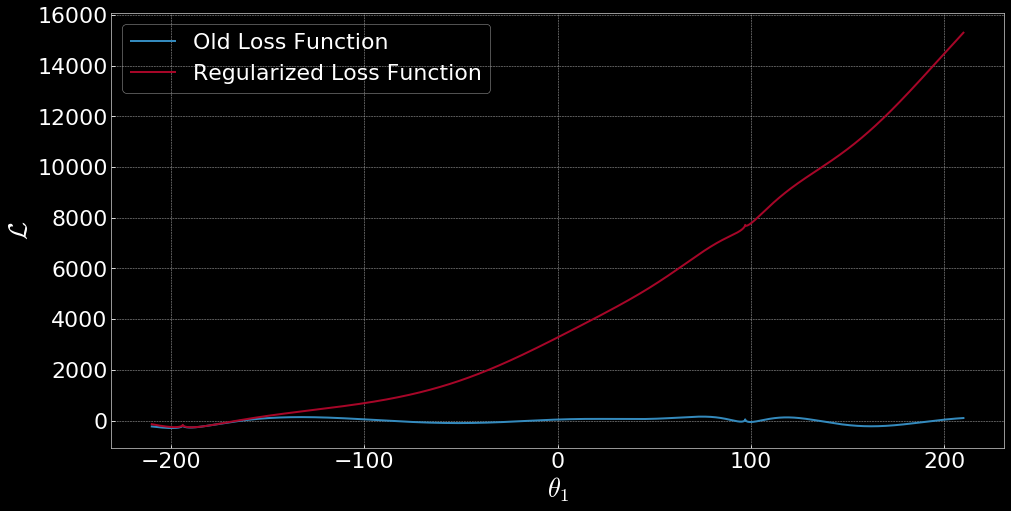

In [33]:
plot_regularized_loss(regularization_strength=0.1)

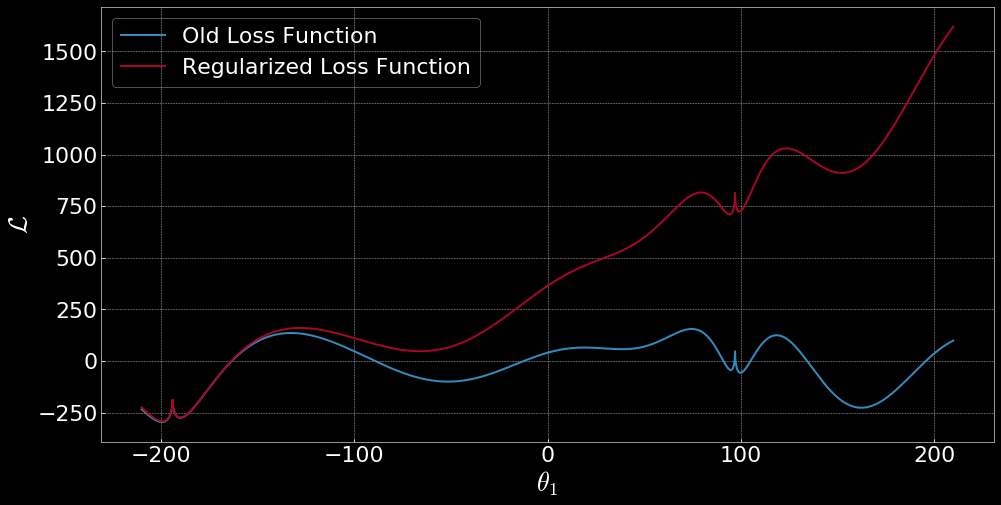

In [34]:
plot_regularized_loss(regularization_strength=0.01)

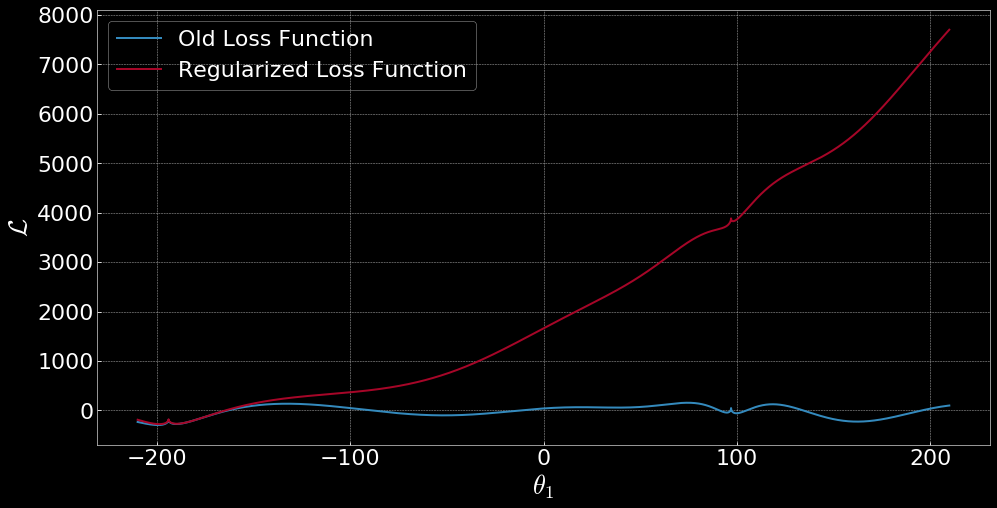

In [35]:
plot_regularized_loss(regularization_strength=0.05)

Clearly, too large of a regularization strength and the only function the optimizer will "see" is the regularizer. If the regularizer has a minima that does not coincide with the loss function's global minima, then you will also see the global minima position change. Too small of a regularization strength and the hills are still too large to overcome. Therefore, this is **another** hyperparameter that needs to be optimized independent of the model's parameters optimization. 

The obvious question here is "How do we know what regularizer to create/pick?" and that is an open ended question. There are some popular choices which we will discuss in future labs but the answer is really we don't know. This is where domain expertise comes in handy as you can choose to throw in extra terms into your loss function to eliminate behavior via regularization that you know is non-optimal. If you include multiple regularizers in your loss function each regularizer should have its own regularization strength since each regularization function likely has a different scale dependence and therefore will need its own regularization strength.

## Exercise 1
Make histograms comparing Gradient Descent's performance with Adam's performance for regularization strengths,  $\lambda \in \left[0.1, 0.01, 0.05\right]$ for the above regularizer.

In [ ]:
# regularized loss here
def regularized_loss(regularization_strength):
    

In [167]:
# lambda = 0.1 here

gradient_descent_losses = [] # store final loss from gradient descent in this list

N = 100 # Do 100 random trials to benchmark performance of pure gradient descent

for i in range(N): # 100 random trials
    theta1 = 420 * (torch.rand(1) - 0.5) # sample theta randomly between -210 to 210
    theta1.requires_grad = True
    # Try setting plotting = True to inspect the differences between Adam and Gradient descent
    # but don't let N be too large - might kill your PC/Jupyter Notebook session
    gradient_descent_losses.append(derivative_descent(theta=theta1, T=3000, alpha=0.1, plotting=False, loss=regularized_loss(0.1)))
    
# Note I am changing the default hyperparameters of Adam to give it "more momentum" or "less friction"
# beta1 = 0.9 is default, I am giving it 0.9999
# beta2 = 0.999 is default
# I am also giving it more time since because there is more momentum we need to give it more time to stop
# oscillating. You can go ahead and give more time to gradient descent but it won't change anything
adam_descent_losses = []

for i in range(N):
    theta1_i = 420 * (torch.rand(1) - 0.5) # sample theta1 randomly between -210 to 210
    theta1_i.requires_grad = True
    adam_descent_losses.append(adam_descent(theta1=theta1_i, T=5000, alpha=0.001, betas=(0.9, 0.999), plotting=False), loss=regularized_loss(0.1))

In [168]:
# lambda = 0.01 here

gradient_descent_losses = [] # store final loss from gradient descent in this list

N = 100 # Do 100 random trials to benchmark performance of pure gradient descent

for i in range(N): # 100 random trials
    theta1 = 420 * (torch.rand(1) - 0.5) # sample theta randomly between -210 to 210
    theta1.requires_grad = True
    # Try setting plotting = True to inspect the differences between Adam and Gradient descent
    # but don't let N be too large - might kill your PC/Jupyter Notebook session
    gradient_descent_losses.append(derivative_descent(theta=theta1, T=3000, alpha=0.1, plotting=False, loss=regularized_loss(0.01)))
    
# Note I am changing the default hyperparameters of Adam to give it "more momentum" or "less friction"
# beta1 = 0.9 is default, I am giving it 0.9999
# beta2 = 0.999 is default
# I am also giving it more time since because there is more momentum we need to give it more time to stop
# oscillating. You can go ahead and give more time to gradient descent but it won't change anything
adam_descent_losses = []

for i in range(N):
    theta1_i = 420 * (torch.rand(1) - 0.5) # sample theta1 randomly between -210 to 210
    theta1_i.requires_grad = True
    adam_descent_losses.append(adam_descent(theta1=theta1_i, T=5000, alpha=0.001, betas=(0.9, 0.999), plotting=False), loss=regularized_loss(0.01))

In [169]:
# lambda = 0.05 here

gradient_descent_losses = [] # store final loss from gradient descent in this list

N = 100 # Do 100 random trials to benchmark performance of pure gradient descent

for i in range(N): # 100 random trials
    theta1 = 420 * (torch.rand(1) - 0.5) # sample theta randomly between -210 to 210
    theta1.requires_grad = True
    # Try setting plotting = True to inspect the differences between Adam and Gradient descent
    # but don't let N be too large - might kill your PC/Jupyter Notebook session
    gradient_descent_losses.append(derivative_descent(theta=theta1, T=3000, alpha=0.1, plotting=False, loss=regularized_loss(0.05)))
    
# Note I am changing the default hyperparameters of Adam to give it "more momentum" or "less friction"
# beta1 = 0.9 is default, I am giving it 0.9999
# beta2 = 0.999 is default
# I am also giving it more time since because there is more momentum we need to give it more time to stop
# oscillating. You can go ahead and give more time to gradient descent but it won't change anything
adam_descent_losses = []

for i in range(N):
    theta1_i = 420 * (torch.rand(1) - 0.5) # sample theta1 randomly between -210 to 210
    theta1_i.requires_grad = True
    adam_descent_losses.append(adam_descent(theta1=theta1_i, T=5000, alpha=0.001, betas=(0.9, 0.999), plotting=False), loss=regularized_loss(0.05))

## Exercise 2
Calculate how much the global minima position shifted by introducing the different regularization strengths, $\lambda \in \left[0.1, 0.01, 0.05\right]$ for the above regularizer.

In [ ]:
# generate all theta1s here and fix theta2_0 = 50

In [170]:
# lambda = 0.1 here
min(loss(theta1, theta2_0)) - min(regularized_loss(0.1))

In [171]:
# lambda = 0.01 here
min(loss(theta1, theta2_0)) - min(regularized_loss(0.01))

In [ ]:
# lambda = 0.05 here
min(loss(theta1, theta2_0)) - min(regularized_loss(0.05))